# Softmax Classifier 
Using a softmax regression function on image recognization.

Softmax classifier is a linear classifier, we won't expect much in accuray because images are highly nonlinear with both high-frequency and low-frequency data. Vision is a  complicated system somehow can abstract huge data into simple perception. The interesting part of this project is what features are extracted by this first order classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities.data_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load preprocessed CIFAR-10 data
# Mean image has been substracted from test, validation and training
# images to normalize the data
# Images has been flatten to NxD (N test cases, D features)
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

# Print out data shape to verify
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


In [3]:
# Define Softmax Classifier in Vanilla Python/Numpy

class LinearClassifier(object):
  """ 
  Linear Classifier with stochastic gradient descent
  """

  def __init__(self):
    self.W = None
    self.b = None

  def train(self, X, y, 
            learning_rate=1e-3, 
            reg=1e-5, 
            num_iters=100,
            batch_size=200, 
            verbose=False):
    """
    Train the linear classifier using SGD.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.0001 * np.random.randn(dim, num_classes)
        
    if self.b is None:
        self.b = 0.0001 * np.random.randn(num_classes)
        
    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
      X_batch = None
      y_batch = None
        
      idxs = np.random.choice(num_train, size=batch_size, replace=True)
      X_batch = X[idxs,:]
      y_batch = y[idxs]


      # evaluate loss and gradient
      loss, dw_grad, db_grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      self.W += - dw_grad * learning_rate
      self.b += - db_grad * learning_rate

      if verbose and it % 100 == 0:
        print 'iteration %d / %d: loss %f' % (it, num_iters, loss)

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    
    scores = X.dot(self.W)
    y_pred = np.argmax(scores, axis=1)

    return y_pred
  
    

class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
      """
      Softmax loss function.
      Inputs have dimension D, there are C classes, and we operate on minibatches
      of N examples.

      Inputs:
      - W: A numpy array of shape (D, C) containing weights.
      - b: A numpy array of shape (C,) for bias
      - X_batch: A numpy array of shape (N, D) containing a minibatch of data.
      - y_batch: A numpy array of shape (N,) containing training labels; y[i] = c means
        that X[i] has label c, where 0 <= c < C.
      - reg: (float) regularization strength

      Returns a tuple of:
      - loss as single float
      - gradient with respect to weights W; an array of same shape as W

      """
      loss = 0.0
      dW = np.zeros_like(self.W) 
      N = X_batch.shape[0]
      scores = np.dot(X_batch, self.W) + self.b
      # Numerically stable softmax probability
      probs = np.exp(scores - np.max(scores, axis=1, keepdims=True))
      probs = probs / np.sum(probs, axis=1, keepdims=True)
      loss = -np.sum(np.log(probs[xrange(N), y_batch])) / N
      loss += 0.5 * reg * np.sum(self.W**2)
      dscores = probs.copy()
      dscores[xrange(N), y_batch] -= 1
      dscores /= N
      dW = X_batch.T.dot(dscores) + reg * self.W
      db = np.sum(dscores, axis=0)
      
      return loss, dW, db

In [4]:
#Sanity Check on loss function
softmax = Softmax()

softmax.train(X_dev, y_dev, learning_rate=0, 
            reg=0, 
            num_iters=0,
            batch_size=0, 
            verbose=False)

#softmax.W = np.random.randn(3072, 10) * 0.0001
#softmax.b = np.random.randn(10) * 0.0001
loss, dW, db = softmax.loss(X_dev, y_dev, 0.0)
print loss
# Loss value should be around log(0.1) = 2.3

2.37010671374


In [5]:
# Search hyper parameters for the best combination
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8, 1e-7, 5e-7]
regularization_strengths = [1e4, 5e4, 1e3]

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
   
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 5.000000e-08 reg 1.000000e+03 train accuracy: 0.363510 val accuracy: 0.363000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.357327 val accuracy: 0.380000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.326776 val accuracy: 0.342000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.379347 val accuracy: 0.399000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.371061 val accuracy: 0.386000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.326571 val accuracy: 0.342000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.408571 val accuracy: 0.408000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.371735 val accuracy: 0.387000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.329143 val accuracy: 0.343000
best validation accuracy achieved during cross-validation: 0.408000


In [6]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.394000


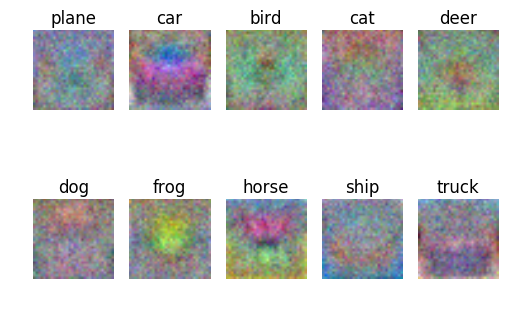

In [7]:
# Visualize the learned weights for each class
w = best_softmax.W
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])